# Cohort 5 Screening

Bartosz Kusek

## Task 3
For this problem you have the following situation: you are playing a game of tic-tac-toe, and you find the situation in the figure below, next is your turn, develop a quantum algorithm to be able to find the best decisions with higher probability.

```
X | O | O
X |   | 
O |   | 
```

The following considerations apply:
You are the X's.
The matrix as a qubit and the state of the X's is $|1>$ and of the O's is $|0>$, of the empty cells an unknown state.
What are the valid combinations to win?
You have at most 2 turns

## Solution
 As the hint states, there is a finite set of winning combinations. Given the initial state of the board, we can quickly find 2 complements granting the win for the "X" player. This optimize the number of qbits required by the oracle - the other way would be to implement checks for all 8 winning combinations and counters for "X" and "O" characters being intermediate results of the oracle.

The idea behind the solution is to initialize quantum state representing all possible final states of the board (disregarding the rules, i.e. even four "X"s) and use Grover Search algorithm to find the winning combination.

### Preliminaries

Now I include all required dependencies and define helpers that I find useful.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

import numpy as np

I'll use Aer to benchmark obtained results.

In [2]:
# backend we will use
aer_simulator = Aer.get_backend('aer_simulator')

# gets the result for given circuit from aer simulator
def run_on_aer(circ):
    transpiled_qc = transpile(circ, aer_simulator)
    qobj = assemble(transpiled_qc)
    result = aer_simulator.run(qobj).result()
    return result

# plots probabilities of all states
def plot_aer_counts(aer_result):
    return plot_histogram(aer_result.get_counts())

List of sub-boards we will look for. I denote "X" as 1 and "O" as 0.

In [3]:
winning_boards = list(map(np.array, [[
    [1, 1],
    [0, 0]
], [
    [1, 0],
    [0, 1]
]]))

winning_boards

[array([[1, 1],
        [0, 0]]),
 array([[1, 0],
        [0, 1]])]

Let N be the number of blank fileds on the board.

In [4]:
# class encapsulating the cirucit. It allows convenient access to individual registers
class TicTacToe:
    def __init__(self, N=4):
        self.N = N
        self.board_reg = QuantumRegister(N, 'q')
        self.oracle_reg = QuantumRegister(1, 'o')
        self.measurements = ClassicalRegister(N, 'r')
        self.circ = QuantumCircuit(self.board_reg, self.oracle_reg, self.measurements)

In [5]:
# applies measure gates on address register   
def measure(tictac):
    for i in range(tictac.N):
        tictac.circ.measure(tictac.board_reg[i], i)

## Grover Search
Let's proceed with the elements needed to run the search algorithm.

### 1. Oracle
We need oracle which identifies two winning states. It may use only 1 qbit for the output, as both states are mutually exclusive. Oracle checks all 4 qbits with multi controlled X gate.

In [6]:
# (2,2) boards flatten to (4) for easier access
boards_flatten = [board.reshape(4) for board in winning_boards]
boards_flatten

[array([1, 1, 0, 0]), array([1, 0, 0, 1])]

In [7]:
# build oracle on tictac cirle. The oracle finds subboards from desired list
def build_oracle(tictac, desired):
    for board in desired:
        for (i, v) in enumerate(board):
            if v == 0:
                tictac.circ.x(tictac.board_reg[i])
            
        tictac.circ.mcx(tictac.board_reg, tictac.oracle_reg)
        
        for (i, v) in enumerate(board):
            if v == 0:
                tictac.circ.x(tictac.board_reg[i])

### 2. Diffuser
The diffuser is implemented as described in the literature (for simplest instruction see [qiskit textbook](https://qiskit.org/textbook/ch-algorithms/grover.html)).

In [8]:
# build diffuser on the tictac circuit
def build_diffuser(tictac):
    for i in range(tictac.N):
        tictac.circ.h(tictac.board_reg[i])

    for i in range(tictac.N):
        tictac.circ.x(tictac.board_reg[i])

    tictac.circ.h(tictac.board_reg[tictac.N-1])
    tictac.circ.mcx(tictac.board_reg[:tictac.N-1], tictac.board_reg[tictac.N-1])
    tictac.circ.h(tictac.board_reg[tictac.N-1])
    
    for i in range(tictac.N):
        tictac.circ.x(tictac.board_reg[i])
        
    for i in range(tictac.N):
        tictac.circ.h(tictac.board_reg[i])
        
    tictac.circ.barrier()

### 3. Circuit Initialization

We initialize the address register as the superposition of all addresses and the Oracle output as `|->`.

In [9]:
# initializes circuit for the Grover algorithm
def initialize_circ(tictac):
    for i in range(tictac.N):
        tictac.circ.h(tictac.board_reg[i])

    tictac.circ.initialize([1, -1]/np.sqrt(2), tictac.oracle_reg)
    tictac.circ.barrier()

### 4. Grover's Iteration
Now we have all components to compose a single iteration of the algorithm.

In [10]:
# builts single Grover's iteration on qram circuit
def add_iteration(tictac, boards):
    build_oracle(tictac, boards)
    build_diffuser(tictac)
    return tictac

### Solution
Here we wrap all introduced components and make a method running Grover's search on Aer simulator. Finding optimal number of iterations requires us to know $k$, the number of states we are looking for. We know it, however, in case of unkown $k$, we may find it experimentaly.

In [11]:
# returns the number of iterations to get a near-optimal measurement for search space of size N
# while looking for k entries
def goal_iterations(N, k):
    return int(np.floor(np.pi/4*np.sqrt(N/k)))

In [12]:
def solution(tictac, boards):
    initialize_circ(tictac)

    for i in range(goal_iterations(2**tictac.N, len(boards))):
        add_iteration(tictac, boards)
    
    measure(tictac)
    res = run_on_aer(tictac.circ)
    return res

{'1000': 5, '0001': 4, '1110': 6, '1010': 6, '1111': 2, '1101': 3, '0110': 6, '0100': 5, '1001': 511, '0111': 1, '0011': 446, '0000': 5, '0010': 6, '1100': 3, '0101': 6, '1011': 9}


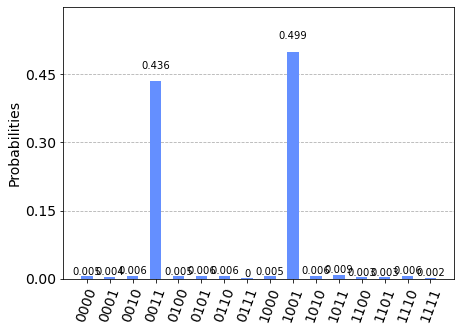

In [13]:
tictac = TicTacToe()
res = solution(tictac, boards_flatten)

print(res.get_counts())
plot_aer_counts(res)

As shown on the plot, Grover Algorithm did great, since there were 2 states out of 16 we were looking for. Greater number of winning states could decrease the probability of finding winning state.